In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from typing import List, Dict, Any, Tuple, Optional

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import MaxNLocator
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.version.cuda)
print(torch.cuda.is_available())


Using device: cuda
12.1
True


In [2]:
csv_path = 'datasets_56102_107707_monthly-beer-production-in-austr.csv'
df = pd.read_csv(csv_path, parse_dates=['Month'], index_col='Month')

In [3]:
def make_sliding_windows(series: np.ndarray, dates: np.ndarray, T: int):
    X, Y, Y_dates = [], [], []
    for t in range(T, len(series)):
        X.append(series[t-T:t])
        Y.append(series[t])
        Y_dates.append(dates[t])
    X = np.array(X).reshape(-1, T, 1)
    Y = np.array(Y).reshape(-1)
    Y_dates = np.array(Y_dates)
    return X, Y, Y_dates

def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    return mae, rmse

In [4]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, units=128, num_layers=1, dropout=0.0, bidirectional=False):
        super().__init__()
        self.units = units
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=units,
                            num_layers=num_layers,
                            dropout=dropout if num_layers > 1 else 0.0,
                            batch_first=True,
                            bidirectional=bidirectional)
        out_dim = units * (2 if bidirectional else 1)
        self.head = nn.Linear(out_dim, 1)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        last = out[:, -1, :]
        y = self.head(last).squeeze(-1)
        return y

In [5]:
def sample_hyperparams():
    units = random.choice((16, 32, 64, 128, 256))
    num_layers = random.choice((1, 2, 3, 4, 5))
    dropout = random.uniform(0.0, 0.3)
    lr = 10 ** random.uniform(math.log10(1e-4), math.log10(5e-3))
    T = random.choice((6, 12, 24, 36))
    batch_size = random.choice((16, 32, 64, 128))
    return dict(units=units, num_layers=num_layers, dropout=dropout,
                lr=lr, T=T, batch_size=batch_size)

In [6]:
def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer, criterion, clip=1.0):
    model.train()
    running = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        optimizer.step()
        running += loss.item() * xb.size(0)
        n += xb.size(0)
    return running / n

def evaluate(model: nn.Module, loader: DataLoader, criterion):
    model.eval()
    running = 0.0
    n = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            running += loss.item() * xb.size(0)
            n += xb.size(0)
    return running / n

In [ ]:
# Random search hyperparameter tuning
def random_search(df: pd.DataFrame,
                  n_trials: int = 100,
                  epochs: int = 60,
                  early_stop: int = 8,
                  verbose: int = 1, # 0 = silent, 1 = detailed, 2 = trials only
                  seed: int = 0) -> Tuple[List[Dict[str,Any]], Optional[Dict[str,Any]]]:
    
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    colname = df.columns[0]
    series_vals = df[colname].values.astype(float)
    dates = df.index.to_numpy()
    results: List[Dict[str, Any]] = []

    train_end = np.datetime64('1983-09-01')
    val_end = np.datetime64('1989-08-01')

    # Record best results to overwrite when a better trial appears
    global_best_val = float('inf')
    best_record = None

    for tnum in range(1, n_trials + 1):
        h = sample_hyperparams()
        T = h['T']
        batch_size = h['batch_size']

        X_all, Y_all, Y_dates = make_sliding_windows(series_vals, dates, T)

        train_idx = np.where(Y_dates <= train_end)[0]
        val_idx = np.where((Y_dates > train_end) & (Y_dates <= val_end))[0]
        test_idx = np.where(Y_dates > val_end)[0]

        X_train = X_all[train_idx]
        Y_train = Y_all[train_idx]

        X_val = X_all[val_idx]
        Y_val = Y_all[val_idx]

        X_test = X_all[test_idx]
        Y_test = Y_all[test_idx]
        dates_test = Y_dates[test_idx]

        # Scaling fit on training data only
        scaler_X = StandardScaler().fit(X_train.reshape(-1, 1))
        X_train_s = scaler_X.transform(X_train.reshape(-1, 1)).reshape(-1, T, 1)
        X_val_s = scaler_X.transform(X_val.reshape(-1, 1)).reshape(-1, T, 1)
        X_test_s = scaler_X.transform(X_test.reshape(-1, 1)).reshape(-1, T, 1)

        scaler_y = StandardScaler().fit(Y_train.reshape(-1, 1))
        Y_train_s = scaler_y.transform(Y_train.reshape(-1, 1)).reshape(-1)
        Y_val_s = scaler_y.transform(Y_val.reshape(-1, 1)).reshape(-1)
        Y_test_s = scaler_y.transform(Y_test.reshape(-1, 1)).reshape(-1)

        train_ds = TensorDataset(torch.tensor(X_train_s, dtype=torch.float32),
                                 torch.tensor(Y_train_s, dtype=torch.float32))
        val_ds = TensorDataset(torch.tensor(X_val_s, dtype=torch.float32),
                               torch.tensor(Y_val_s, dtype=torch.float32))
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model = LSTMForecast(input_size=1,
                             units=h['units'],
                             num_layers=h['num_layers'],
                             dropout=h['dropout']).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=h['lr'])
        criterion = nn.MSELoss()
        
        best_val = float('inf')
        wait = 0
        best_weights = None
        train_losses_epoch = []
        val_losses_epoch = []

        if verbose == 1:
            print(f'Trial {tnum}/{n_trials} params: units={h['units']} layers={h['num_layers']} drop={h['dropout']:.3f} lr={h['lr']:.2e} T={T} bs={batch_size}')

        for epoch in range(1, epochs + 1):
            tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
            val_loss = evaluate(model, val_loader, criterion)
            train_losses_epoch.append(tr_loss)
            val_losses_epoch.append(val_loss)

            if val_loss < best_val - 1e-12:
                best_val = float(val_loss)
                wait = 0
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            else:
                wait += 1

            if verbose == 1 and (epoch == 1 or (epoch % 10 == 0)):
                print(f'epoch {epoch:03d} train={tr_loss:.6f} val={val_loss:.6f} wait={wait}')

            if wait >= early_stop:
                if verbose == 1:
                    print(f'Early stopping at epoch {epoch} (wait={wait})')
                break

        # Restore best weights
        if best_weights is not None:
            model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

        model.eval()
        val_preds = []
        with torch.no_grad():
            for xb, _ in val_loader:
                xb = xb.to(device)
                out = model(xb).cpu().numpy()
                val_preds.append(out)
        if len(val_preds) == 0:
            val_preds = np.array([]).reshape(-1)
        else:
            val_preds = np.concatenate(val_preds, axis=0).reshape(-1)

        val_preds_unscaled = scaler_y.inverse_transform(val_preds.reshape(-1, 1)).reshape(-1)
        val_true_unscaled = scaler_y.inverse_transform(Y_val_s.reshape(-1, 1)).reshape(-1)
        val_mae, val_rmse = compute_metrics(val_true_unscaled, val_preds_unscaled)

        # Test evaluation using the model selected on validation
        test_preds = []
        test_ds = TensorDataset(torch.tensor(X_test_s, dtype=torch.float32),
                                torch.tensor(Y_test_s, dtype=torch.float32))
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
        with torch.no_grad():
            for xb, _ in test_loader:
                xb = xb.to(device)
                out = model(xb).cpu().numpy()
                test_preds.append(out)
        if len(test_preds) == 0:
            test_preds = np.array([]).reshape(-1)
        else:
            test_preds = np.concatenate(test_preds, axis=0).reshape(-1)
        test_preds_unscaled = scaler_y.inverse_transform(test_preds.reshape(-1, 1)).reshape(-1)
        test_true_unscaled = scaler_y.inverse_transform(Y_test_s.reshape(-1, 1)).reshape(-1)
        test_mae, test_rmse = compute_metrics(test_true_unscaled, test_preds_unscaled)

        trial_res = {
            'trial': tnum,
            'params': h,
            'val_loss_scaled': float(best_val),
            'val_mae': float(val_mae),
            'val_rmse': float(val_rmse),
            'test_mae': float(test_mae),
            'test_rmse': float(test_rmse)
        }
        results.append(trial_res)

        # Overwrite global best if improved
        if best_val < global_best_val - 1e-12:
            global_best_val = float(best_val)
            best_record = {
                'trial': tnum,
                'params':h,
                'val_loss_scaled': float(best_val),
                'scaler_X': scaler_X,
                'scaler_Y': scaler_y,
                'test_dates': pd.to_datetime(dates_test),
                'y_test_true': test_true_unscaled.copy(),
                'y_test_pred': test_preds_unscaled.copy(),
                'model_state_cpu': {k: v.cpu().clone() for k, v in best_state.items()} if best_state is not None else None,
                'loss_history': {
                    'train': train_losses_epoch.copy(),
                    'val': val_losses_epoch.copy()
                },
                'test_mae': float(test_mae),
                'test_rmse': float(test_rmse)
            }
        
        if verbose == 1:
            print(f'VAL MAE={val_mae:.3f}, VAL RMSE={val_rmse:.3f}\n')
        elif verbose == 2 and (tnum % 10 == 0 or tnum == n_trials):
            print(f'Trial {tnum}/{n_trials}')
        
    results = sorted(results, key=lambda x: x['val_loss_scaled'])
    return results, best_record

In [8]:
results, best = random_search(df, n_trials=200, epochs=40, early_stop=8, verbose=2) 
print('Top 3 by validation loss:')
for r in results[:3]:
    print(f'trial {r['trial']:3d} | val_rmse={r['val_rmse']:3f} | val_loss={r['val_loss_scaled']:.6f} | params={r['params']}')

top_by_test = sorted(results, key=lambda x: x.get('test_rmse', float('inf')))[:3]
print('\nTop 3 by test RMSE:')
for r in top_by_test:
    print(f'trial {r['trial']:3d} | test_rmse={r['test_rmse']:3f} | val_loss={r['val_loss_scaled']:.6f} | params={r['params']}')

val_rec = results[0]
print('Best model (selected by lowest validation loss)')
print(f'trial={val_rec['trial']} | val_loss={val_rec['val_loss_scaled']:.6f} | '
      f'val_mae={(val_rec['val_mae']):.3f} | val_rmse={val_rec['val_rmse']:.3f} | '
      f'test_mae={val_rec['test_mae']:.3f} | test_rmse={val_rec['test_rmse']:.3f}')
print(f'Params: {val_rec['params']}')

Trial 10/200
Trial 20/200
Trial 30/200
Trial 40/200
Trial 50/200
Trial 60/200
Trial 70/200
Trial 80/200
Trial 90/200
Trial 100/200
Trial 110/200
Trial 120/200
Trial 130/200
Trial 140/200
Trial 150/200
Trial 160/200
Trial 170/200
Trial 180/200
Trial 190/200
Trial 200/200
Top 3 by validation loss:
trial  30 | val_rmse=15.334499 | val_loss=0.138114 | params={'units': 128, 'num_layers': 3, 'dropout': 0.046023831279427274, 'lr': 0.0014917194210185031, 'T': 36, 'batch_size': 16}
trial 106 | val_rmse=13.234060 | val_loss=0.138423 | params={'units': 32, 'num_layers': 3, 'dropout': 0.034337167669760235, 'lr': 0.004602100642573721, 'T': 24, 'batch_size': 32}
trial  61 | val_rmse=14.300927 | val_loss=0.142712 | params={'units': 256, 'num_layers': 2, 'dropout': 0.031388906831972374, 'lr': 0.0006009267255788826, 'T': 24, 'batch_size': 32}

Top 3 by test RMSE:
trial  28 | test_rmse=10.324315 | val_loss=0.160580 | params={'units': 256, 'num_layers': 3, 'dropout': 0.03516385316131574, 'lr': 0.00367673

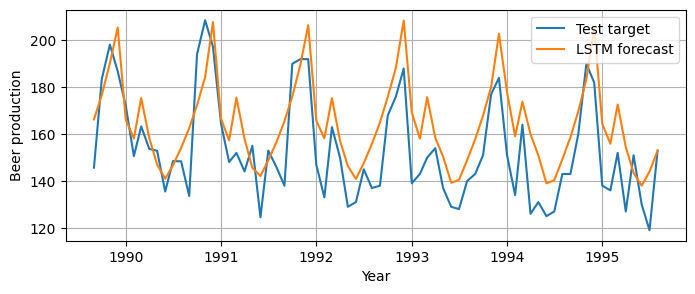

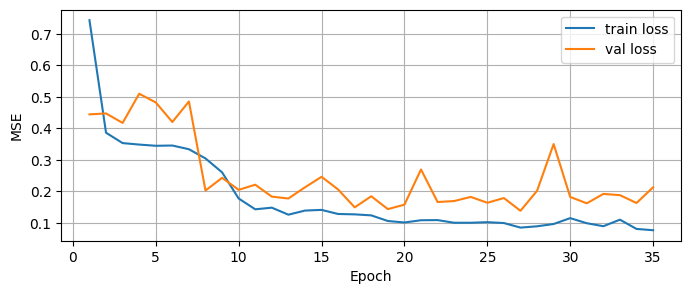

In [9]:
if best is not None:
    # Forecast plot 
    plt.figure(figsize=(8, 3))
    plt.plot(best['test_dates'], best['y_test_true'], label='Test target')
    plt.plot(best['test_dates'], best['y_test_pred'], label='LSTM forecast')
    plt.xlabel('Year')
    plt.ylabel('Beer production')
    plt.legend()
    plt.grid(True)
    plt.show()

    lh = best['loss_history']
    plt.figure(figsize=(8,3))
    plt.plot(np.arange(1, len(lh['train'])+1), lh['train'], label='train loss')
    plt.plot(np.arange(1, len(lh['val'])+1), lh['val'], label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

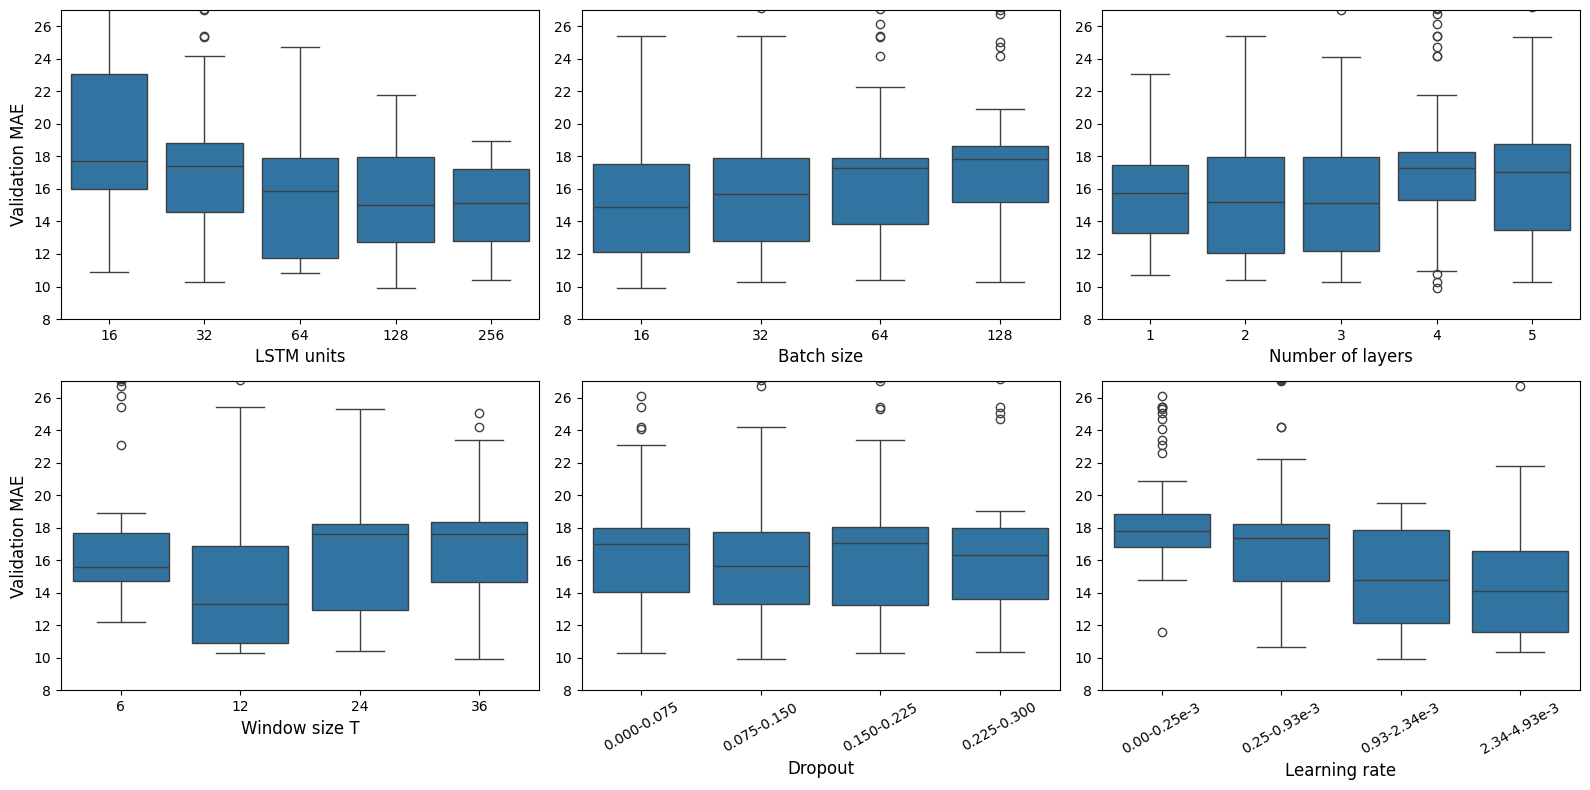

In [10]:
df_res = pd.DataFrame(results)
hyperparams_df = df_res['params'].apply(pd.Series)

int_cols = ['units', 'batch_size', 'num_layers', 'T']
for col in int_cols:
    if col in hyperparams_df.columns:
        hyperparams_df[col] = hyperparams_df[col].astype(int)

# dropout binned and prettified
if 'dropout' in hyperparams_df.columns:
    hyperparams_df['dropout_bin'] = pd.cut(hyperparams_df['dropout'], bins=4)
    labels = [f'{iv.left:.3f}-{iv.right:.3f}' for iv in hyperparams_df['dropout_bin'].cat.categories]
    hyperparams_df['dropout_bin'] = hyperparams_df['dropout_bin'].cat.rename_categories(labels)

# learning rate quartile bins and formatted labels
if 'lr' in hyperparams_df.columns:
    lr_values = hyperparams_df['lr'].astype(float).clip(lower=0)
    try:
        hyperparams_df['lr_bin'] = pd.qcut(lr_values, q=4, duplicates='drop')
        cleaned = [pd.Interval(max(iv.left, 0), max(iv.right, 0)) for iv in hyperparams_df['lr_bin'].cat.categories]
        edges = [i.left for i in cleaned] + [i.right for i in cleaned]
        exponent = int(np.floor(np.log10(max(edges)))) if max(edges) > 0 else 0
        formatted = []
        for iv in cleaned:
            left = iv.left / (10**exponent) if exponent != 0 else iv.left
            right = iv.right / (10**exponent) if exponent != 0 else iv.right
            formatted.append(f'{left:.2f}-{right:.2f}e{exponent:+d}')
        hyperparams_df['lr_bin'] = hyperparams_df['lr_bin'].cat.rename_categories(formatted)
    except ValueError:
        hyperparams_df['lr_bin'] = pd.cut(lr_values, bins=4)

evaluation_df = pd.concat([hyperparams_df, df_res['val_mae']], axis=1)

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
y_limits = (8, 27)
label_fontsize = 12

plot_map = [
    ('units', 'LSTM units', axes[0,0]),
    ('batch_size', 'Batch size', axes[0,1]),
    ('num_layers', 'Number of layers', axes[0,2]),
    ('dropout_bin', 'Dropout', axes[1,1]),
    ('lr_bin', 'Learning rate', axes[1,2]),
    ('T', 'Window size T', axes[1,0])
]

tilted_xticks = {'dropout_bin', 'lr_bin'}

for key, xlabel, ax in plot_map:
    if key not in evaluation_df.columns:
        ax.axis('off')
        continue
    # convert numeric categories to strings for cleaner category ticks
    if pd.api.types.is_numeric_dtype(evaluation_df[key]):
        order = sorted(evaluation_df[key].unique())
    else:
        order = evaluation_df[key].cat.categories

    sns.boxplot(x=key, y='val_mae', data=evaluation_df, ax=ax)

    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    if ax in (axes[0,0], axes[1,0]):
        ax.set_ylabel('Validation MAE', fontsize=label_fontsize)
    else:
        ax.set_ylabel('')
    
    ax.set_ylim(y_limits)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    if key in tilted_xticks:
        for lbl in ax.get_xticklabels():
            lbl.set_rotation(30)
    else:
        for lbl in ax.get_xticklabels():
            lbl.set_rotation(0)

plt.tight_layout()
plt.show()
